# Effecti of the fiber displacement (no centered source) on the effciency for  Moffat and Gaussian distribution

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#import time
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from photutils.centroids import centroid_com
from astropy.modeling.models import Moffat2D
from astropy.table import Table


In [4]:
# Define the Moffat function
def moffat_2d(x, y, x0, y0, alpha, beta, I0):
    r = np.sqrt((x - x0)**2 + (y - x0)**2)
    return I0 * (1 + (r / alpha)**2)**(-beta)

In [5]:
# Define circular fiber aperture mask
def fiber_aperture(x, y, fiber_x, fiber_y, fiber_radius_pix):
    r = np.sqrt((x - fiber_x)**2 + (y - fiber_y)**2)
    return r <= fiber_radius_pix

In [6]:
#Data from ESO ETC for Giraffe

eso_x = [0,0.10,0.20,0.30,0.40,0.50,0.60]
eso_y = [0.501,0.491,0.471,0.443,0.406,0.359,0.304]

# Let's try with Moffat profiles...

[[2.28477416e-08 2.42005583e-08 2.56328294e-08 ... 3.41283008e-08
  3.22374947e-08 3.04467262e-08]
 [2.42005583e-08 2.56623184e-08 2.72122764e-08 ... 3.64511831e-08
  3.43885788e-08 3.24383346e-08]
 [2.56328294e-08 2.72122764e-08 2.88896095e-08 ... 3.89382425e-08
  3.66878072e-08 3.45635695e-08]
 ...
 [3.41283008e-08 3.64511831e-08 3.89382425e-08 ... 5.42436869e-08
  5.07582880e-08 4.74980806e-08]
 [3.22374947e-08 3.43885788e-08 3.66878072e-08 ... 5.07582880e-08
  4.75652095e-08 4.45727641e-08]
 [3.04467262e-08 3.24383346e-08 3.45635695e-08 ... 4.74980806e-08
  4.45727641e-08 4.18261618e-08]]


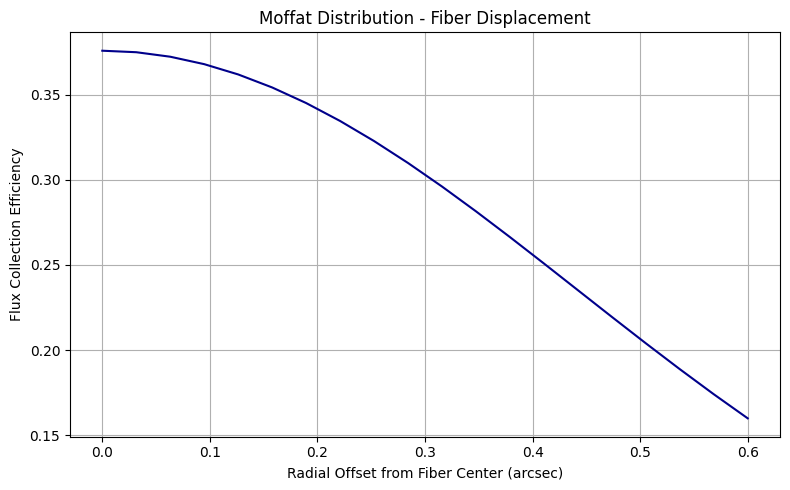

In [7]:

# ---------------- Simulation Setup ----------------
size = 100  # Grid size
arcsec_per_pixel = 0.3  # Plate scale
x = np.arange(0, size)
y = np.arange(0, size)
X, Y = np.meshgrid(x, y)

# Fibre parameters
fiber_diameter_arcsec = 1.2
fiber_radius_pix = (fiber_diameter_arcsec / 2) / arcsec_per_pixel
fiber_x, fiber_y = size // 2, size // 2  # Centered fiber
fiber_mask = fiber_aperture(X, Y, fiber_x, fiber_y, fiber_radius_pix)

# Moffat PSF parameters
fwhm_arcsec = 1.2
beta = 3.0
I0 = 1.0
fwhm_pix = fwhm_arcsec / arcsec_per_pixel
alpha = fwhm_pix / (2 * np.sqrt(2**(1 / beta) - 1))

# Radial offsets in arcseconds
offsets_arcsec = np.linspace(0.0, 0.6, 20)
efficiencies = []

# Sweep over offsets
for offset_arcsec in offsets_arcsec:
    offset_pix = offset_arcsec / arcsec_per_pixel
    angle_rad = 0  # Fixed angle (e.g., 0°), since Moffat is symmetric

    source_x = fiber_x + offset_pix * np.cos(angle_rad)
    source_y = fiber_y + offset_pix * np.sin(angle_rad)

    moffat_image = moffat_2d(X, Y, source_x, source_y, alpha, beta, I0)
    total_flux = np.sum(moffat_image)
    captured_flux = np.sum(moffat_image * fiber_mask)
    efficiency = captured_flux / total_flux
    efficiencies.append(efficiency)

print(moffat_image)

# ---------------- Plotting ----------------
plt.figure(figsize=(8, 5))
plt.plot(offsets_arcsec, efficiencies, color='darkblue')
plt.xlabel('Radial Offset from Fiber Center (arcsec)')
plt.ylabel('Flux Collection Efficiency')
plt.title('Moffat Distribution - Fiber Displacement')
plt.grid(True)
plt.tight_layout()

#plt.savefig('MoffatDistribution_FiberDisplacement.pdf')
plt.show()

## Graphical representation of the displacement

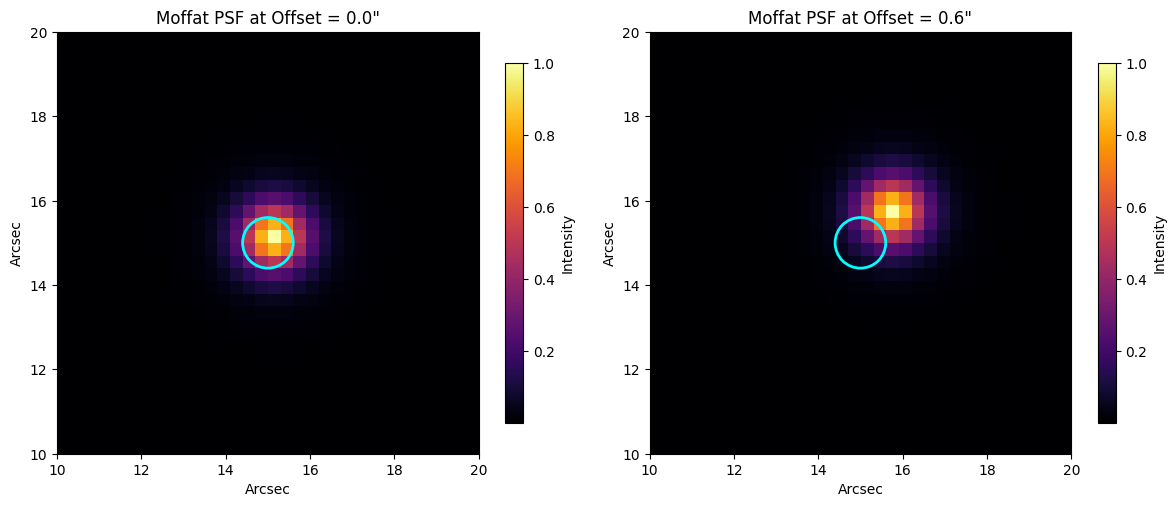

In [8]:

# Generate two Moffat PSF images for visualization
offsets_to_plot = [0.0, 0.6]  # arcsec
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, offset_arcsec in enumerate(offsets_to_plot):
    offset_pix = offset_arcsec / arcsec_per_pixel
    source_x = fiber_x + offset_pix
    source_y = fiber_y

    moffat_img = moffat_2d(X, Y, source_x, source_y, alpha, beta, I0)
    
    ax = axes[i]
    im = ax.imshow(moffat_img, origin='lower', cmap='inferno',
                   extent=[0, size*arcsec_per_pixel, 0, size*arcsec_per_pixel])
    
    # Draw fiber circle (convert center and radius to arcsec)
    fiber_center_arcsec = (fiber_x * arcsec_per_pixel, fiber_y * arcsec_per_pixel)
    fiber_radius_arcsec = fiber_radius_pix * arcsec_per_pixel
    circle = patches.Circle(fiber_center_arcsec, fiber_radius_arcsec,
                            edgecolor='cyan', facecolor='none', linewidth=2)
    ax.add_patch(circle)

    ax.set_title(f'Moffat PSF at Offset = {offset_arcsec:.1f}"')
    ax.set_xlabel('Arcsec')
    ax.set_ylabel('Arcsec')
    ax.set_xlim(10,20)
    ax.set_ylim(10,20)
    fig.colorbar(im, ax=ax, shrink=0.8, label='Intensity')

plt.tight_layout()
plt.show()


# Let's try now with a Gaussian distribution

In [9]:
# Define the Gaussian 2D function
def gaussian_2d(x, y, x0, y0, sigma, I0):
    r2 = (x - x0)**2 + (y - y0)**2
    return I0 * np.exp(-r2 / (2 * sigma**2))

# Since Giraffe consideres a gaussian distribution, we can compare them...

Computation time for flux efficiency curve: 0.0008 seconds
[[0.00000e+000 0.00000e+000 0.00000e+000 ... 0.00000e+000 0.00000e+000
  0.00000e+000]
 [0.00000e+000 0.00000e+000 0.00000e+000 ... 0.00000e+000 0.00000e+000
  0.00000e+000]
 [0.00000e+000 0.00000e+000 0.00000e+000 ... 0.00000e+000 0.00000e+000
  0.00000e+000]
 ...
 [0.00000e+000 0.00000e+000 0.00000e+000 ... 2.28955e-319 0.00000e+000
  0.00000e+000]
 [0.00000e+000 0.00000e+000 0.00000e+000 ... 0.00000e+000 0.00000e+000
  0.00000e+000]
 [0.00000e+000 0.00000e+000 0.00000e+000 ... 0.00000e+000 0.00000e+000
  0.00000e+000]]


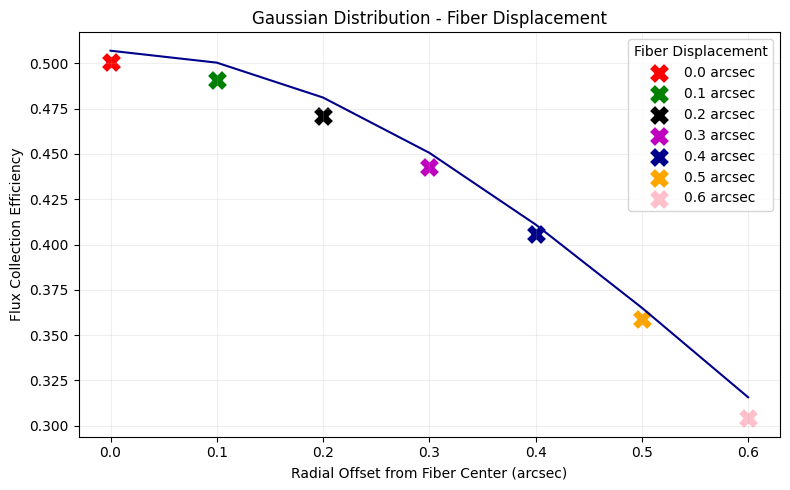

In [22]:

# ---------------- Simulation Setup ----------------
size = 100  # Grid size
arcsec_per_pixel = 0.3  # Plate scale
x = np.arange(0, size)
y = np.arange(0, size)
X, Y = np.meshgrid(x, y)

# Fiber parameters
fiber_diameter_arcsec = 1.2
fiber_radius_pix = (fiber_diameter_arcsec / 2) / arcsec_per_pixel
fiber_x, fiber_y = size // 2, size // 2  # Centered fiber
fiber_mask = fiber_aperture(X, Y, fiber_x, fiber_y, fiber_radius_pix)

# Gaussian PSF parameters
fwhm_arcsec = 1.2
I0 = 1.0
sigma_pix = (fwhm_arcsec / arcsec_per_pixel) / (2 * np.sqrt(2 * np.log(2)))

# Radial offsets in arcseconds
offsets_arcsec = np.linspace(0.0, 0.6, 7)
efficiencies = []

start_time = time.time()  # Start timer
# Sweep over offsets
for offset_arcsec in offsets_arcsec:
    offset_pix = offset_arcsec / arcsec_per_pixel
    angle_rad = 0  

    source_x = fiber_x + offset_pix * np.cos(angle_rad)
    source_y = fiber_y + offset_pix * np.sin(angle_rad)

    psf_image = gaussian_2d(X, Y, source_x, source_y, sigma_pix, I0)
    total_flux = np.sum(psf_image)
    captured_flux = np.sum(psf_image * fiber_mask)
    efficiency = captured_flux / total_flux
    efficiencies.append(efficiency)

end_time = time.time()  # End timer
print(f"Computation time for flux efficiency curve: {end_time - start_time:.4f} seconds")


print(psf_image)

eso_x = [0,0.10,0.20,0.30,0.40,0.50,0.60]
eso_y = [0.501,0.491,0.471,0.443,0.406,0.359,0.304]

colors = ['r','g','k','m','darkblue','orange','pink']
eso_f = [0.0,2.0,5.9,11.5,19.0,28.3,39.4]
# ---------------- Plotting ----------------
plt.figure(figsize=(8, 5))
plt.plot(offsets_arcsec, efficiencies, color='darkblue')

for i in range(0,len(colors)):
    plt.scatter(eso_x[i], eso_y[i], marker='x', lw=5.0, color=colors[i], label=str(np.round(offsets_arcsec[i],1))+' arcsec', s=100)

#plt.scatter(eso_x,eso_y, marker='x', color='orange')
plt.xlabel('Radial Offset from Fiber Center (arcsec)')
plt.ylabel('Flux Collection Efficiency')
plt.title('Gaussian Distribution - Fiber Displacement')
plt.legend(title='Fiber Displacement')
plt.grid(True, alpha=0.2)
plt.tight_layout()

#plt.savefig('GaussianDistribution_FiberDisplacement.pdf')

plt.show()

## Graphical representation of the displacement

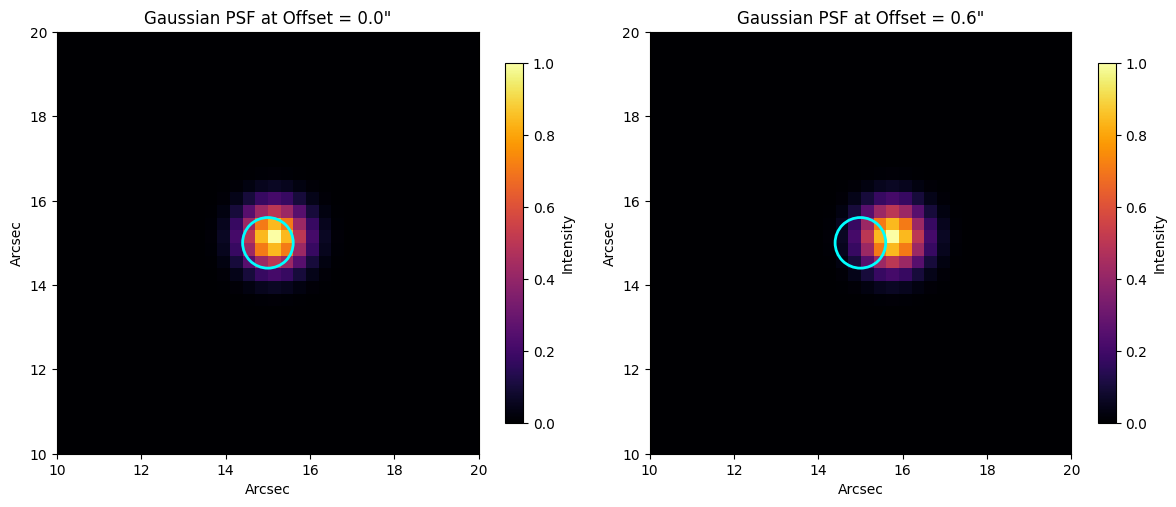

In [27]:

# Generate two Gaussian PSF images for visualization
offsets_to_plot = [0.0, 0.6]  # arcsec
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


for i, offset_arcsec in enumerate(offsets_to_plot):
    offset_pix = offset_arcsec / arcsec_per_pixel
    source_x = fiber_x + offset_pix
    source_y = fiber_y

    gaussian_img = gaussian_2d(X, Y, source_x, source_y, sigma_pix, I0)

    ax = axes[i]
    im = ax.imshow(gaussian_img, origin='lower', cmap='inferno',
                   extent=[0, size*arcsec_per_pixel, 0, size*arcsec_per_pixel])
    
    # Draw fiber circle (in arcsec)
    fiber_center_arcsec = (fiber_x * arcsec_per_pixel, fiber_y * arcsec_per_pixel)
    fiber_radius_arcsec = fiber_radius_pix * arcsec_per_pixel
    circle = patches.Circle(fiber_center_arcsec, fiber_radius_arcsec,
                            edgecolor='cyan', facecolor='none', linewidth=2)
    ax.add_patch(circle)

    ax.set_title(f'Gaussian PSF at Offset = {offset_arcsec:.1f}"')
    ax.set_xlabel('Arcsec')
    ax.set_ylabel('Arcsec')
    ax.set_xlim(10,20)
    ax.set_ylim(10,20)
    fig.colorbar(im, ax=ax, shrink=0.8, label='Intensity')

plt.tight_layout()
plt.show()


## For a direct comparison:

In [23]:
offsets_arcsec

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

In [24]:
efficiencies

[0.5070213143993089,
 0.500433358877513,
 0.4811641090980578,
 0.4506380727732283,
 0.411041129480402,
 0.3650695020049516,
 0.3156348849288663]

In [25]:
eso_f = [0.0,2.0,5.9,11.5,19.0,28.3,39.4]

fib_disp = [] 

for i in range(0,len(offsets_arcsec)):
    fib_disp.append(100-((efficiencies[i]*100)/efficiencies[0]))

#fib_disp

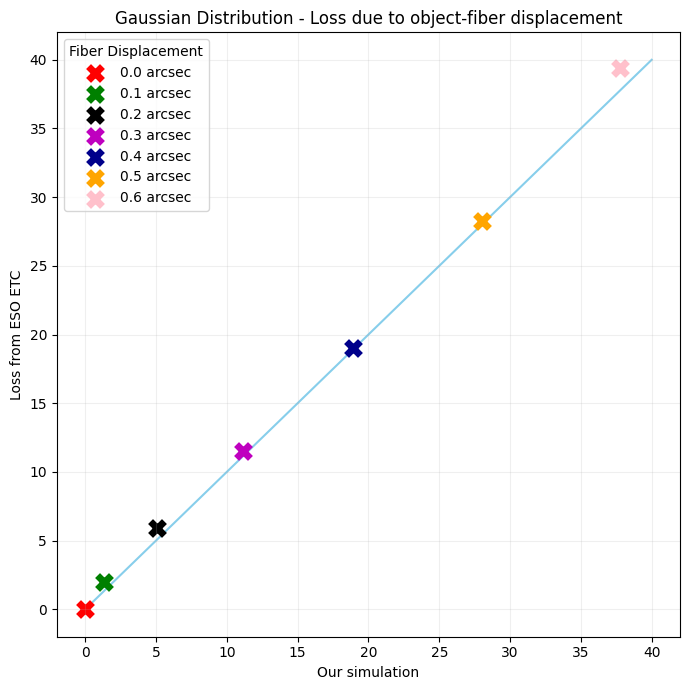

In [26]:
colors = ['r','g','k','m','darkblue','orange','pink']

# ---------------- Plotting ----------------
plt.figure(figsize=(7, 7))

for i in range(0,len(colors)):
#    plt.plot(x, moffat_profile, label='Moffat (β='+str(betas[i])+')', color=colors[i], linestyle='--', lw=2)
    plt.scatter(fib_disp[i], eso_f[i], marker='x', lw=5.0, color=colors[i], label=str(np.round(offsets_arcsec[i],1))+' arcsec', s=100)


plt.plot([0.0,40], [0.0,40], color='skyblue', zorder=0)
#plt.scatter(fib_disp, eso_f, marker='x', color='orange', s=80)
plt.xlabel('Our simulation')
plt.ylabel('Loss from ESO ETC')
plt.title('Gaussian Distribution - Loss due to object-fiber displacement')
plt.legend(title='Fiber Displacement')
plt.grid(True,alpha=0.2)
plt.tight_layout()

#plt.savefig('GaussianDistribution_LossFiberDisplacement.pdf')

plt.show()

